# NCSU GIS/MEA582:
# Geospatial Modeling and Analysis
## Section 5 - Geomorphology
### 5A - Terrain Modeling

Setup GRASS GIS Environment

In [1]:
# Import Python standard library and IPython packages we need.
import os
import subprocess
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS 
#set path to match your own dataset
gj.init("grassdata", "nc_basic_spm_grass7", "user1")

# Set computational region to elevation raster
gs.run_command("g.region", raster="elevation", flags="pg")

### Analyze bare earth and multiple return lidar data properties by binning

Import the points using v.in.lidar. We can specify which class and which return (first, middle, last) we want to import.
We can see the classification either in metadata distributed with the lidar data or it can be displayed with lasinfo tool (in case lasinfo command is not available, skip it.):

> Switch from lastools to PDAL

In [3]:
%%bash
pdal info tile_0793_016_spm.las

{
  "file_size": 48886422,
  "filename": "tile_0793_016_spm.las",
  "now": "2021-10-21T16:41:50-0400",
  "pdal_version": "2.1.0 (git-version: Release)",
  "reader": "readers.las",
  "stats":
  {
    "bbox":
    {
      "EPSG:4326":
      {
        "bbox":
        {
          "maxx": -78.66289768,
          "maxy": 35.76907108,
          "maxz": 718.63,
          "minx": -78.67135306,
          "miny": 35.76217982,
          "minz": 54.75
        },
        "boundary": { "type": "Polygon", "coordinates": [ [ [ -78.671353056088265, 35.762202850610002, 54.75 ], [ -78.671325155696451, 35.76907108242149, 54.75 ], [ -78.66289767657932, 35.769048050708442, 718.63 ], [ -78.662926292348075, 35.762179820800938, 718.63 ], [ -78.671353056088265, 35.762202850610002, 54.75 ] ] ] }
      },
      "native":
      {
        "bbox":
        {
          "maxx": 640081.28,
          "maxy": 224028.45,
          "maxz": 718.63,
          "minx": 639319.28,
          "miny": 223266.45,
          "minz": 54.

Class 2 represents bare earth points.
Now we import bare earth points and first return points separately:

In [4]:
gs.run_command("v.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="elev_lid793016_be", 
               class_filter=2, overwrite=True)
gs.run_command("v.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="elev_lid793016_1r", 
               return_filter="first", overwrite=True)

Set the region from the imported point file with resolution of 1 meter. Compute raster maps (with r.in.lidar) representing number of points per 1 m grid cell.
Compare point densities for bare earth, first return.

In [5]:
gs.run_command("g.region", vect="elev_lid793016_1r", res=1, flags="p")

gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_be_binn1m",
               method="n", # number of points in cell
               input_srs="EPSG:4326",
               class_filter=2,
               flags="o",
               overwrite=True)

gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_1r_binn1m",
               method="n", # number of points in cell
               input_srs="EPSG:4326",
               return_filter="first", 
               flags="o",
               overwrite=True)

gs.run_command("r.colors", map="lid_be_binn1m,lid_1r_binn1m", color="bcyr", flags="e")


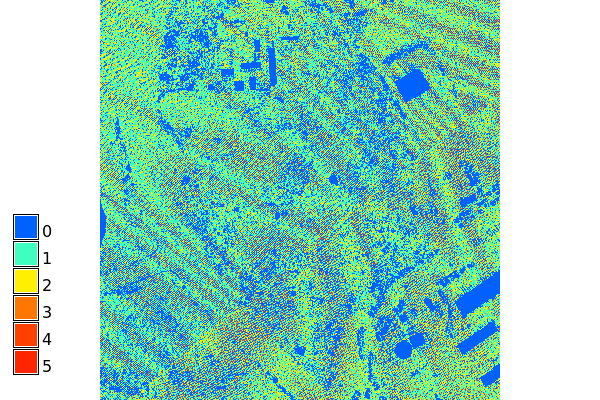

In [6]:
lidar_map_be = gj.GrassRenderer()
lidar_map_be.d_rast(map="lid_be_binn1m")
lidar_map_be.d_legend(raster="lid_be_binn1m", at=(2,50,2,9))
lidar_map_be.show()

In [7]:
gs.parse_command("r.report", map="lid_be_binn1m", unit="p,c")


{'+-----------------------------------------------------------------------------+': None,
 '|                         RASTER MAP CATEGORY REPORT                          |': None,
 '|LOCATION: nc_basic_spm_grass7                        Thu Oct 21 16:42:51 2021|': None,
 '|-----------------------------------------------------------------------------|': None,
 '|          north: 224028.45    east: 640081.28                                |': None,
 '|REGION    south: 223266.45    west: 639319.28                                |': None,
 '|          res:           1    res:          1                                |': None,
 '|MASK: none                                                                   |': None,
 '|MAP: Raw X,Y,Z data binned into a raster grid by cell n (lid_be_binn1m in use|': None,
 '|                     Category Information                      |   %  |  cell|': None,
 '|#|description                                                  | cover| count|': None,
 '|0| . . 

In [8]:
gs.parse_command("r.univar", map="lid_be_binn1m")

{'total null and non-null cells: 580644': None,
 'total null cells: 0': None,
 '': None,
 'Of the non-null cells:': None,
 '----------------------': None,
 'n: 580644': None,
 'minimum: 0': None,
 'maximum: 5': None,
 'range: 5': None,
 'mean: 0.96483': None,
 'mean of absolute values: 0.96483': None,
 'standard deviation: 0.905149': None,
 'variance: 0.819295': None,
 'variation coefficient: 93.8143 %': None,
 'sum: 560223': None}

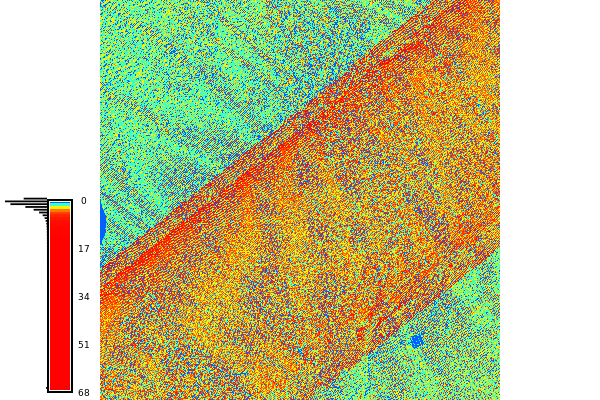

In [9]:
lidar_map_1r = gj.GrassRenderer()
lidar_map_1r.d_rast(map="lid_1r_binn1m")
lidar_map_1r.d_legend(raster="lid_1r_binn1m", at=(2,50,8,12), flags="ds")
lidar_map_1r.show()

In [10]:
gs.parse_command("r.report", map="lid_1r_binn1m", unit="p,c")

{'+-----------------------------------------------------------------------------+': None,
 '|                         RASTER MAP CATEGORY REPORT                          |': None,
 '|LOCATION: nc_basic_spm_grass7                        Thu Oct 21 16:43:19 2021|': None,
 '|-----------------------------------------------------------------------------|': None,
 '|          north: 224028.45    east: 640081.28                                |': None,
 '|REGION    south: 223266.45    west: 639319.28                                |': None,
 '|          res:           1    res:          1                                |': None,
 '|MASK: none                                                                   |': None,
 '|MAP: Raw X,Y,Z data binned into a raster grid by cell n (lid_1r_binn1m in use|': None,
 '|                     Category Information                      |   %  |  cell|': None,
 '| #|description                                                 | cover| count|': None,
 '| 0| . .

In [11]:
gs.parse_command("r.univar", map="lid_1r_binn1m")

{'total null and non-null cells: 580644': None,
 'total null cells: 0': None,
 '': None,
 'Of the non-null cells:': None,
 '----------------------': None,
 'n: 580644': None,
 'minimum: 0': None,
 'maximum: 68': None,
 'range: 68': None,
 'mean: 2.33184': None,
 'mean of absolute values: 2.33184': None,
 'standard deviation: 2.41605': None,
 'variance: 5.83732': None,
 'variation coefficient: 103.611 %': None,
 'sum: 1353970': None}

Compute a raster map representing mean elevation for each 1m cell.
It will have holes.

In [12]:
gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_be_binmean1m",
               method="mean", # number of points in cell
               input_srs="EPSG:4326",
               class_filter=2,
               flags="o",
               overwrite=True)

gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_1r_binmean1m",
               method="mean", # number of points in cell
               input_srs="EPSG:4326",
               return_filter="first", 
               flags="o",
               overwrite=True)

gs.run_command("r.colors", map="lid_be_binmean1m", color="elevation")
gs.run_command("r.colors", map="lid_1r_binmean1m", color="elevation")

In [13]:
gs.parse_command("r.info", map="lid_1r_binmean1m")

{'+----------------------------------------------------------------------------+': None,
 '| Map:      lid_1r_binmean1m               Date: Thu Oct 21 16:46:56 2021    |': None,
 '| Mapset:   user1                          Login of Creator: coreywhite      |': None,
 '| Location: nc_basic_spm_grass7                                              |': None,
 '| DataBase: /home/coreywhite/Documents/grassdata                             |': None,
 '| Title:    Raw X,Y,Z data binned into a raster grid by cell mean            |': None,
 '| Timestamp: none                                                            |': None,
 '|----------------------------------------------------------------------------|': None,
 '|                                                                            |': None,
 '|   Type of Map:  raster               Number of Categories: 0               |': None,
 '|   Data Type:    FCELL                Band reference: (none)                |': None,
 '|   Rows:         7

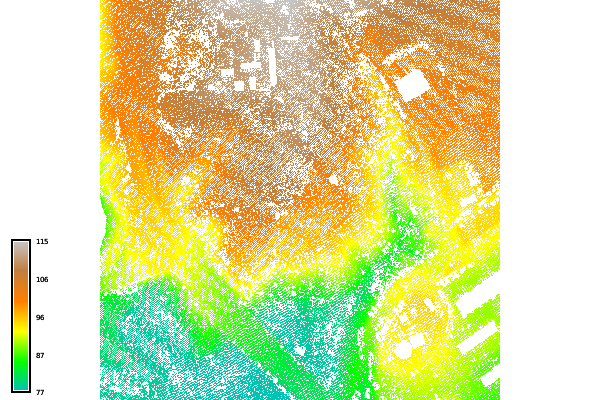

In [15]:
lid_be_binmean1m_map = gj.GrassRenderer(filename="output/lid_be_binmean1m.png")
lid_be_binmean1m_map.d_rast(map="lid_be_binmean1m")
lid_be_binmean1m_map.d_legend(raster="lid_be_binmean1m", at=(2,40,2,5))
lid_be_binmean1m_map.show()

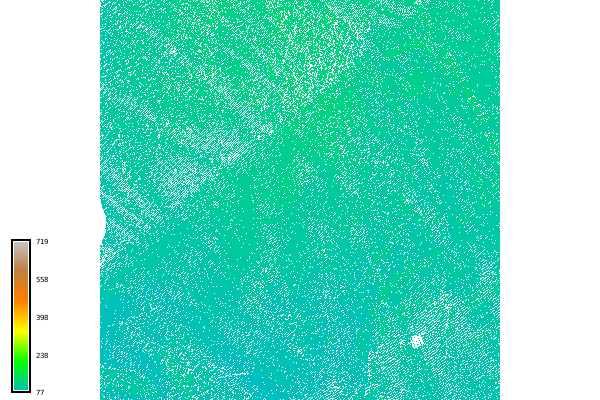

In [17]:
lid_1r_binmean1m_map = gj.GrassRenderer(filename="output/mylidmrmean1m.png")
lid_1r_binmean1m_map.d_rast(map="lid_1r_binmean1m")
lid_1r_binmean1m_map.d_legend(raster="lid_1r_binmean1m", at=(2,40,2,5))
lid_1r_binmean1m_map.show()

Compute a raster map representing mean elevation for each 2m cell.
Result is almost good enough for 1st return, but there are still many holes for bare earth.

In [21]:
gs.run_command("g.region", res=2, flags="ap")

gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_be_binmean2m",
               method="mean", # number of points in cell
               input_srs="EPSG:4326",
               class_filter=2,
               flags="o",
               overwrite=True)

gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_1r_binmean2m",
               method="mean", # number of points in cell
               input_srs="EPSG:4326",
               return_filter="first", 
               flags="o",
               overwrite=True)

gs.run_command("r.colors", map="lid_be_binmean2m", color="elevation")
gs.run_command("r.colors", map="lid_1r_binmean2m", color="elevation")


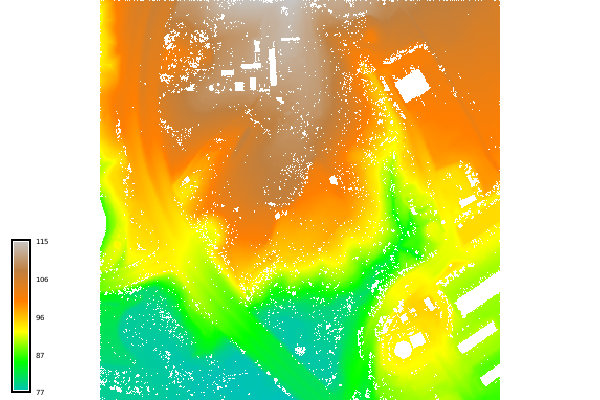

In [23]:
lid_be_binmean2m_map = gj.GrassRenderer(filename="output/lid_be_binmean2m.png")
lid_be_binmean2m_map.d_rast(map="lid_be_binmean2m")
lid_be_binmean2m_map.d_legend(raster="lid_be_binmean2m", at=(2,40,2,5))
lid_be_binmean2m_map.show()


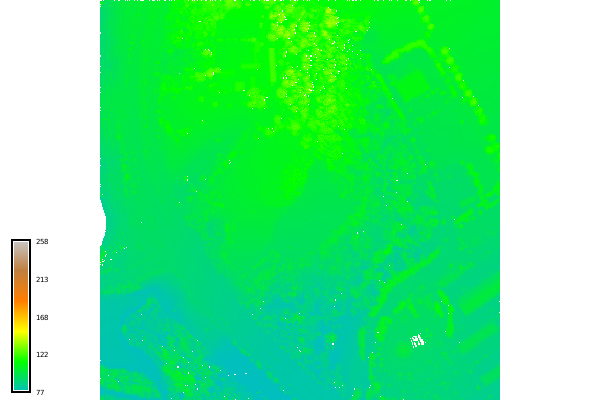

In [24]:
lid_1r_binmean2m_map = gj.GrassRenderer(filename="output/mylidmrmean2m.png")
lid_1r_binmean2m_map.d_rast(map="lid_1r_binmean2m")
lid_1r_binmean2m_map.d_legend(raster="lid_1r_binmean2m", at=(2,40,2,5))
lid_1r_binmean2m_map.show()

Compute range of elevation values in each grid cell:

In [25]:
gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_be_binrange2m",
               method="range", # number of points in cell
               input_srs="EPSG:4326",
               class_filter=2,
               flags="o",
               overwrite=True)

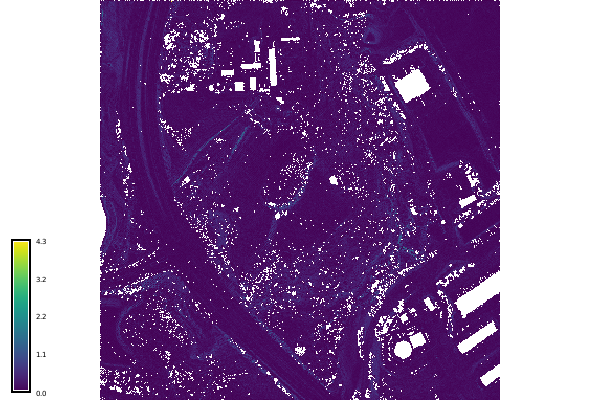

In [26]:
lid_be_binrange2m_map = gj.GrassRenderer(filename="output/lid_be_binrange2m.png")
lid_be_binrange2m_map.d_rast(map="lid_be_binrange2m")
lid_be_binrange2m_map.d_legend(raster="lid_be_binrange2m", at=(2,40,2,5))
lid_be_binrange2m_map.show()

In [29]:
gs.run_command("r.in.pdal", 
               input="tile_0793_016_spm.las", 
               output="lid_1r_binrange2m",
               method="range", # number of points in cell
               input_srs="EPSG:4326",
               return_filter="first", 
               flags="o",
               overwrite=True)

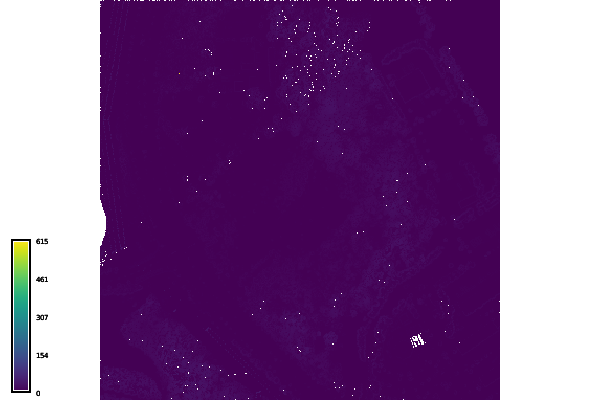

In [30]:
lid_1r_binrange2m_map = gj.GrassRenderer(filename="output/lid_1r_binrange2m.png")
lid_1r_binrange2m_map.d_rast(map="lid_1r_binrange2m")
lid_1r_binrange2m_map.d_legend(raster="lid_1r_binrange2m", at=(2,40,2,5))
lid_1r_binrange2m_map.show()

Import and display orthophoto, switch off all layers except for orthophoto.

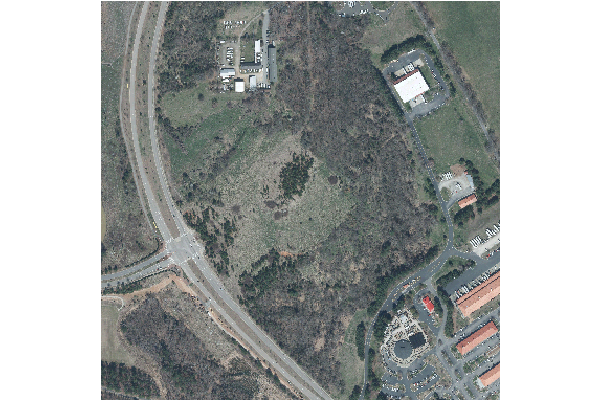

In [32]:
gs.run_command("r.in.gdal", input="ortho_0793_016_ncspm.tif", output="ortho_2013_0793")
ortho_2013_0793_map = gj.GrassRenderer()
ortho_2013_0793_map.d_rast(map="ortho_2013_0793")
ortho_2013_0793_map.show()

Identify the features that are associated with large range values.
Display only the high values of range.

**Question**
> What landcover is associated with large range in multiple return data?

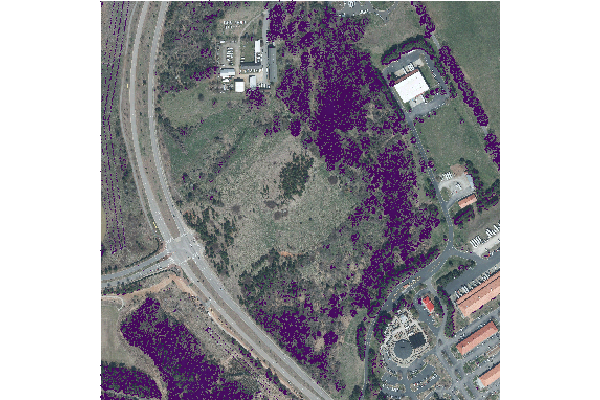

In [33]:
mylid_1rrange2m_map = gj.GrassRenderer(filename="output/mylid_1rrange2m.png")
mylid_1rrange2m_map.d_rast(map="ortho_2013_0793")
mylid_1rrange2m_map.d_rast(map="lid_1r_binrange2m", values="10.-200")
mylid_1rrange2m_map.show()

We now know how dense the data are and what is the range within cell.

**Question**
> If we need a 1m resolution DEM or DSM for our application this analysis tells us that we need to interpolate it from the point cloud. What steps would you begin with when processing point cloud data you are not familiar with?

### Interpolate DEM and DSM

To interpolate DEM and DSM we use default parameters except for number of points used for segmentation and interpolation
(segmax and npmin and higher tension for multiple return data).
You can set dmin=1 to make the interpolation run faster (see the manual).
Be patient, it can take a few minutes to run depending on the computer power.

In [37]:
gs.run_command("g.region", res=1, flags="ap")
gs.run_command("v.surf.rst", 
               input="elev_lid793016_be", 
               elevation="elev_lid793016_be_1m",
               npmin=120,
               segmax=25,
               dmin=1
              )

gs.run_command("v.surf.rst", 
               input="elev_lid793016_1r", 
               elevation="elev_lid793016_1r_1m",
               npmin=120,
               segmax=25,
               tension=100,
               smooth=0.5,
               dmin=1
              )

gs.run_command("r.colors", map="elev_lid793016_be_1m", color="elevation")
gs.run_command("r.colors", map="elev_lid793016_1r_1m", color="elevation")


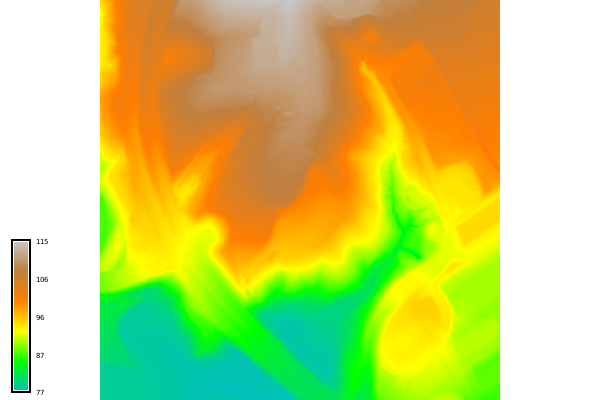

In [38]:
elev_lid793016_be_1m_map = gj.GrassRenderer()
elev_lid793016_be_1m_map.d_rast(map="elev_lid793016_be_1m")
elev_lid793016_be_1m_map.d_legend(raster="elev_lid793016_be_1m", at=(2,40,2,5))
elev_lid793016_be_1m_map.show()

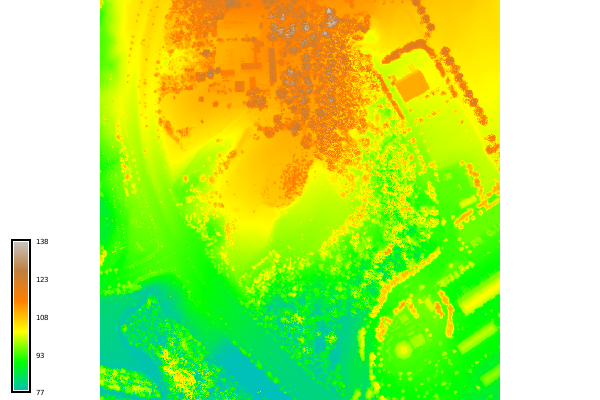

In [39]:
elev_lid793016_1r_1m_map = gj.GrassRenderer()
elev_lid793016_1r_1m_map.d_rast(map="elev_lid793016_1r_1m")
elev_lid793016_1r_1m_map.d_legend(raster="elev_lid793016_1r_1m", at=(2,40,2,5))
elev_lid793016_1r_1m_map.show()

Hide legend and switch off all map layers except for the last 2 interpolated ones.
Use 3D view with cutting planes to compare the bare earth and terrain surface.
Make sure fine resolution is set to 1 for all surfaces.
Assign each surface constant color, add constant plane at 75m elevation for reference.
Shade the crossection using the color by bottom surface option.
If you don't remember this, see screen capture video for 3d view.
Save image for your report.

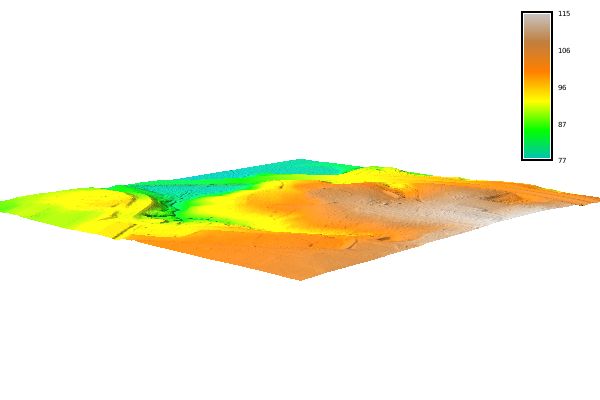

In [40]:
elev_lid793016_be_1m_img = gj.Grass3dRenderer()
elev_lid793016_be_1m_img.render(elevation_map="elev_lid793016_be_1m", color_map="elev_lid793016_be_1m", perspective=20)
elev_lid793016_be_1m_img.overlay.d_legend(raster="elev_lid793016_be_1m", at=(60, 97, 87, 92))
elev_lid793016_be_1m_img.show()

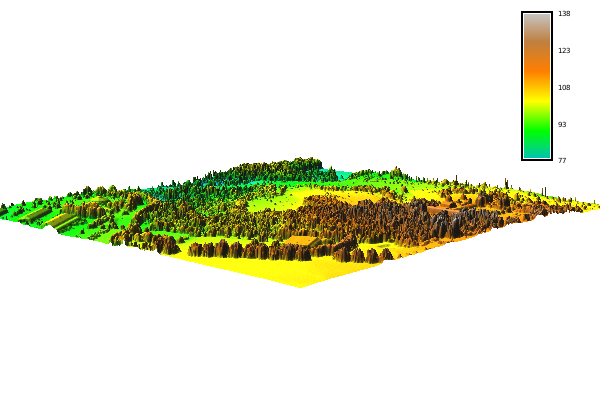

In [41]:
elev_lid793016_1r_1m_img = gj.Grass3dRenderer()
elev_lid793016_1r_1m_img.render(elevation_map="elev_lid793016_1r_1m", color_map="elev_lid793016_1r_1m", perspective=20)
elev_lid793016_1r_1m_img.overlay.d_legend(raster="elev_lid793016_1r_1m", at=(60, 97, 87, 92))
elev_lid793016_1r_1m_img.show()